<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/master/Copia_de_CIFAR10_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR 10

In [ ]:
! git clone https://github.com/cesar-claros/synergistic
% cd synergistic/

## Dependencies

In [ ]:
#%%
# Command line instalation
# ---------------------------
!pip install torch
!pip install gpytorch
!pip install tensorflow-determinism

# Imports
# ---------------------------
import io #Used as buffer
import sys
import matplotlib
import tensorflow as tf # Keras model for MNIST 
# matplotlib.use('qt5Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.funcs as sgn
import auxfunc.trustscore as trs
import seaborn as sns
import torch
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, metrics,\
      tree, neighbors, discriminant_analysis, gaussian_process, preprocessing, impute, decomposition
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
plt.style.use(['ggplot','style/style.mplstyle'])
import os
import random

## Auxiliar Functions

In [3]:
#%%
# Define classic MLP architecture
def CNN_model(input_dim):
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(32,32,3))) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

In [4]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01', ex_dim=1):
    # X_train, X_val should be scaled. ex_dim=1 by default on sgn.signailing
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01, ex_dim=ex_dim)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False), rho_grid=[0.1, 0.15])
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [5]:
#%%
# Initialize model
def init_model(input_dim):
    # svm = False
    # model = MLP_model(input_dim=Data_X.shape[1], svm_obj=svm)
    model  = CNN_model(input_dim=input_dim)
    loss   = tf.keras.losses.categorical_crossentropy
    metric = ['accuracy']
    model.compile(loss=loss,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, 
                                                     beta_2=0.999, epsilon=1e-07, amsgrad=False,
                                                     name='Adam'),
                  metrics=metric)
    return model

In [6]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X):
    y_pred_soft = model.predict(X)
    y_pred_th   = np.argmax(y_pred_soft, axis=1)
    return y_pred_soft, y_pred_th

In [7]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [8]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp,trust_val, trust_test):
      direction = 'further'
      # p_val = np.concatenate(y_val_pred_soft,axis=1)
      crit_val   = entropy(y_val_pred_soft, axis=1, base=10)
      # p_test = np.concatenate(y_test_pred_soft,axis=1)
      crit_test  = entropy(y_test_pred_soft, axis=1, base=10)
      #=== Criteria 1
      critFunc   = sgn.critEvaluation(norm='l01',direction=direction)
      d_val      = critFunc.evaluate(y_val, y_val_pred_th, crit_val, rho_grid=[0.1, 0.15])
      d_test     = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)
      # Threshold values on val data. UCB Signailing (eta) and new criteria (theta) 
      eta        = table['eta'].to_numpy().reshape(-1,1)
      theta      = crit_table['thresh'].to_numpy().reshape(-1,1)
      if direction == 'closer':
        crit_bool = crit_test.reshape(1,-1)<theta   # Boolean of flagged instances
        crit_mask, crit_idx = np.nonzero(crit_bool)
      else:
        crit_bool = crit_test.reshape(1,-1)>theta   # Boolean of flagged instances
        crit_mask, crit_idx = np.nonzero(crit_bool)

      #DF of flagged instances. Criteria
      crit_bool_df = pd.DataFrame(crit_bool).T      
      crit_bool_df.columns = ['crit_rho_grid_0.1','crit_rho_grid_0.15']

      #=== Criteria 2
      critFuncSc = sgn.critEvaluation(norm='l01',direction='closer')
      s_val      = critFuncSc.evaluate(y_val, y_val_pred_th, trust_val, rho_grid=[0.1, 0.15])
      s_test     = critFuncSc.test(y_test, y_test_pred_th, trust_test, s_val['thresh'].to_numpy())
      score_table= pd.concat([s_val,s_test],axis=1)
      # Threshold values on val data. TrustScore (theta0) 
      theta0     = score_table['thresh'].to_numpy().reshape(-1,1) 
      crit_bool0 = trust_test.reshape(1,-1)<theta0
      #DF of flagged instances. Trustscore
      crit_bool0_df = pd.DataFrame(crit_bool0).T      
      crit_bool0_df.columns = ['trust_rho_grid_0.1','trust_rho_grid_0.15']

      #=== Synergystic criteria
      # Best rules from signailing function on val are used to get UCBs on test
      gamma      = table['rule'].to_numpy().reshape(-1,1)
      f_test     = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      f_bool    = f_test>eta
      f_bool_df = pd.DataFrame(f_bool).T      
      f_bool_df.columns = ['syn_rho_grid_0.1','syn_rho_grid_0.15']
      f_mask, f_idx = np.nonzero(f_bool)
      
      # Jaccard index btw signaled instances using both methods for ith rule-threshold
      shared = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask))))
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan for i in range(f_test.shape[0])]
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in range(f_test.shape[0])]
      crit_table['spearman'] = Sp
      crit_table['gamma']    = gamma      
      
      crit_mask0, crit_idx0 = np.nonzero(crit_bool0)
      # Jaccard index btw signaled instances using both methods for ith rule-threshold  
      shared0    = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask0))))
      J0         = [jaccard_similarity(crit_idx0[crit_mask0==i],f_idx[f_mask==i]) if i in shared0 else np.nan for i in range(f_test.shape[0])]
      Sp0        = [spearmanr(f_test[i,:],trust_test)[0] for i in range(f_test.shape[0])]
      score_table['jaccard']  = J0 
      score_table['spearman'] = Sp0  

      #=== Test data results
      idx_signaled = pd.concat([crit_bool_df.reset_index(drop=True),crit_bool0_df.reset_index(drop=True),f_bool_df.reset_index(drop=True)], axis=1)

      return crit_table,score_table,crit_test,idx_signaled

## Signaling function and baselines

In [9]:
# For reproducibility
os.environ['TF_DETERMINISTIC_OPS'] = '1'
SEED = 1234
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [ ]:
# %%
# INITIALIZATION
# ==============
# EXPERIMENT SETUP
# ================
# Load data set
(Data_X, Data_y), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
# y, y_test = y.astype('int8'), y_test.astype('int8')
# Rescale the images from [0,255] to the [0.0,1.0] range.
Data_X, X_test = Data_X[...]/255.0, X_test[...]/255.0
n_cat  = np.unique(np.concatenate([Data_y,y_test]), return_counts=False)
n_cat  = n_cat.size
print("Number of original training examples:", len(Data_X))
print("Number of original testing examples:", len(X_test))
print("---------------")
# Subsample data (30% of original data both in training and testing)
Data_X, Data_X_sep, Data_y, Data_y_sep = model_selection.train_test_split(Data_X, Data_y, stratify=Data_y, test_size=0.75, random_state=SEED)
X_test, X_test_sep, y_test, y_test_sep = model_selection.train_test_split(X_test, y_test, stratify=y_test, test_size=0.75, random_state=SEED)
print("Number of subsampled training examples:", len(Data_X))
print("Number of subsampled testing examples:", len(X_test))

In [11]:
#%%
# Assign labels
report_table    = []
trust_criteria  = []
report_criteria = []
report_plot     = []
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
clf = 'softmax_act'
addPredictions = True
accuracy = 0
fold     = 1
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1)
y_test = tf.keras.utils.to_categorical(y_test)
for train, val in kf.split(Data_X, Data_y):
    if fold>3:
      break
    X_train = Data_X[train]
    y_train = Data_y[train]
    y_train = tf.keras.utils.to_categorical(y_train)
    X_val   = Data_X[val]
    y_val   = Data_y[val]
    y_val   = tf.keras.utils.to_categorical(y_val)

    # ML Model fit & prediction
    model = init_model(input_dim=Data_X.shape[1:])
    # model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=0, validation_data=(X_val, y_val), callbacks=[es])
    model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=0, validation_data=(X_val, y_val))
    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train) # y_train_pred_soft&y_train_pred_th: 10-d vector  
    y_val_pred_soft, y_val_pred_th     = pred_output(model, X_val)   # y_val_pred_soft&y_val_pred_th    : 10-d vector
    y_test_pred_soft, y_test_pred_th   = pred_output(model, X_test)  # y_test_pred_soft&y_test_pred_th  : 10-d vector
    print('accuracy(Train)={}'.format(np.sum(y_train_pred_th==np.argmax(y_train,axis=1))/y_train_pred_th.size))

    # layer_outputs = [layer.output for layer in model.layers[4]]
    if clf == 'softmax_act':
            activation_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[5].output) # Early feture extraction: 128 dense vector
            X_train_GP       = activation_model.predict(X_train)
            X_val_GP         = activation_model.predict(X_val)
            X_test_GP        = activation_model.predict(X_test)
    elif clf == 'softmax':
            X_train_GP       = X_train.reshape(-1,np.prod(X_train.shape[1:]))
            X_val_GP         = X_val.reshape(-1,np.prod(X_val.shape[1:]))
            X_test_GP        = X_test.reshape(-1,np.prod(X_test.shape[1:]))

    if addPredictions:
            # Add predictions
            X_train_GP = np.concatenate((X_train_GP, y_train_pred_soft), axis=1)
            X_val_GP   = np.concatenate((X_val_GP, y_val_pred_soft), axis=1)
            X_test_GP  = np.concatenate((X_test_GP, y_test_pred_soft), axis=1)
    scaleX_GP  = preprocessing.StandardScaler().fit(X_train_GP)
    X_train_GP = scaleX_GP.transform(X_train_GP)
    X_val_GP   = scaleX_GP.transform(X_val_GP)
    X_test_GP  = scaleX_GP.transform(X_test_GP)

    # Signailing function. Call
    table, exp = signalingFunction(X_train_GP, np.argmax(y_train, axis=1), y_train_pred_th, \
                                   X_val_GP, np.argmax(y_val, axis=1), y_val_pred_th,\
                                   X_test_GP, np.argmax(y_test, axis=1), y_test_pred_th,\
                                   kernel='e*e', ex_dim=y_train_pred_soft.shape[1])

    report_table.append(pd.concat([pd.DataFrame({'fold':[fold]*table.shape[0]}),table],axis=1))

    # Trust Score fitted on train data to evaluate loss reduction on val-test data
    trust_model = trs.TrustScore()
    trust_model.fit(X=X_train_GP,Y=y_train,classes=n_cat)
    trust_val,class_val   = trust_model.score(X_val_GP, y_val_pred_th)
    trust_test,class_test = trust_model.score(X_test_GP, y_test_pred_th)
    
    # Baseline for comparison
    crit_table,score_table,crit_test,idx_signaled  = baselineCriteria(np.argmax(y_val, axis=1), y_val_pred_soft, y_val_pred_th,\
                                                        np.argmax(y_test, axis=1), y_test_pred_soft, y_test_pred_th,\
                                                        table, exp,\
                                                        trust_val, trust_test)   
    report_criteria.append(pd.concat([pd.DataFrame({'fold':[fold]*crit_table.shape[0]}),crit_table],axis=1))
    trust_criteria.append(pd.concat([pd.DataFrame({'fold':[fold]*score_table.shape[0]}),score_table],axis=1))

    # Test data flagged instances
    idx_signaled.insert(loc=0, column='y_pred', value=y_test_pred_th)
    idx_signaled.insert(loc=0, column='y_obs', value=np.argmax(y_test, axis=1))
    idx_signaled.insert(loc=0, column='Fold', value=fold)
    idx_signaled['Loss'] = idx_signaled.y_obs != idx_signaled.y_pred    

    score = np.sum(np.argmax(y_val, axis=1)==y_val_pred_th)/np.size(np.argmax(y_val, axis=1))
    if accuracy < score:
      signaled_idx = idx_signaled
      accuracy = score
      table_best = table
      crit_table_best = crit_table
      exp_best = exp
      y_test_best = y_test
      y_test_pred_soft_best = y_test_pred_soft
      y_test_pred_th_best = y_test_pred_th
      X_test_best = X_test        
    del(model)
    fold +=1

accuracy(Train)=0.6128
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.700  noise: 0.183
Iter 492/500 - Loss: 0.700  noise: 0.183
Iter 493/500 - Loss: 0.700  noise: 0.183
Iter 494/500 - Loss: 0.700  noise: 0.183
Iter 495/500 - Loss: 0.700  noise: 0.183
Iter 496/500 - Loss: 0.700  noise: 0.183
Iter 497/500 - Loss: 0.700  noise: 0.183
Iter 498/500 - Loss: 0.700  noise: 0.183
Iter 499/500 - Loss: 0.700  noise: 0.183
Iter 500/500 - Loss: 0.700  noise: 0.183
evaluating with cuda...


/content/synergistic/auxfunc/funcs.py:339: RuntimeWarning: invalid value encountered in true_divide
  'loss_query_val':np.around(np.array(corrected_val_tab)/np.array(queries_val_tab),decimals=2),\


evaluating with cuda...


/content/synergistic/auxfunc/funcs.py:373: RuntimeWarning: invalid value encountered in true_divide
  'loss_query_test':np.around(np.array(corrected_test)/np.array(queries_test),decimals=2),\
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


accuracy(Train)=0.5854
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.711  noise: 0.187
Iter 492/500 - Loss: 0.711  noise: 0.187
Iter 493/500 - Loss: 0.711  noise: 0.187
Iter 494/500 - Loss: 0.711  noise: 0.187
Iter 495/500 - Loss: 0.711  noise: 0.187
Iter 496/500 - Loss: 0.711  noise: 0.187
Iter 497/500 - Loss: 0.711  noise: 0.187
Iter 498/500 - Loss: 0.711  noise: 0.187
Iter 499/500 - Loss: 0.711  noise: 0.187
Iter 500/500 - Loss: 0.711  noise: 0.187
evaluating with cuda...
evaluating with cuda...


/content/synergistic/auxfunc/funcs.py:373: RuntimeWarning: invalid value encountered in true_divide
  'loss_query_test':np.around(np.array(corrected_test)/np.array(queries_test),decimals=2),\


accuracy(Train)=0.5961
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: 0.707  noise: 0.185
Iter 492/500 - Loss: 0.707  noise: 0.185
Iter 493/500 - Loss: 0.707  noise: 0.185
Iter 494/500 - Loss: 0.707  noise: 0.185
Iter 495/500 - Loss: 0.707  noise: 0.185
Iter 496/500 - Loss: 0.707  noise: 0.185
Iter 497/500 - Loss: 0.707  noise: 0.185
Iter 498/500 - Loss: 0.707  noise: 0.185
Iter 499/500 - Loss: 0.707  noise: 0.185
Iter 500/500 - Loss: 0.707  noise: 0.185
evaluating with cuda...
evaluating with cuda...


/content/synergistic/auxfunc/funcs.py:373: RuntimeWarning: invalid value encountered in true_divide
  'loss_query_test':np.around(np.array(corrected_test)/np.array(queries_test),decimals=2),\


## Summary

### Cross validation results

#### Tabular summary

In [12]:
report_table_concat    = pd.concat(report_table)
report_table_concat_gr = report_table_concat.groupby('rho_user').agg({"rho_hat_test":[np.median],"%loss_red_test": [np.median,min, max]})
report_table_concat_gr

rho_hat_test %loss_red_test          
               median         median  min  max
rho_user                                      
0.10              0.0            0.0  0.0  0.0
0.15              0.0            0.0  0.0  0.0

In [13]:
report_criteria_concat    = pd.concat(report_criteria)
report_criteria_concat_gr = report_criteria_concat.groupby('rho_user').agg({"rho_hat_test":[np.median],"%loss_red_test":[np.median,min, max],"jaccard":[np.median,min, max]})
report_criteria_concat_gr

rho_hat_test %loss_red_test               jaccard        
               median         median    min    max  median min max
rho_user                                                          
0.10             0.09          14.70  14.36  14.89     NaN NaN NaN
0.15             0.13          20.83  20.31  21.64     NaN NaN NaN

In [14]:
report_trust_concat    = pd.concat(trust_criteria)
report_trust_concat_gr = report_trust_concat.groupby('rho_user').agg({"rho_hat_test":[np.median],"%loss_red_test":[np.median,min, max],"jaccard":[np.median,min, max]})
report_trust_concat_gr

rho_hat_test %loss_red_test               jaccard        
               median         median    min    max  median min max
rho_user                                                          
0.10             0.09          13.48  13.14  14.52     NaN NaN NaN
0.15             0.14          20.13  20.04  21.92     NaN NaN NaN

#### Graphical display

In [ ]:
#%%
# Command line instalation
# ---------------------------
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

(-0.04950000000000001, 16.475250000000003)

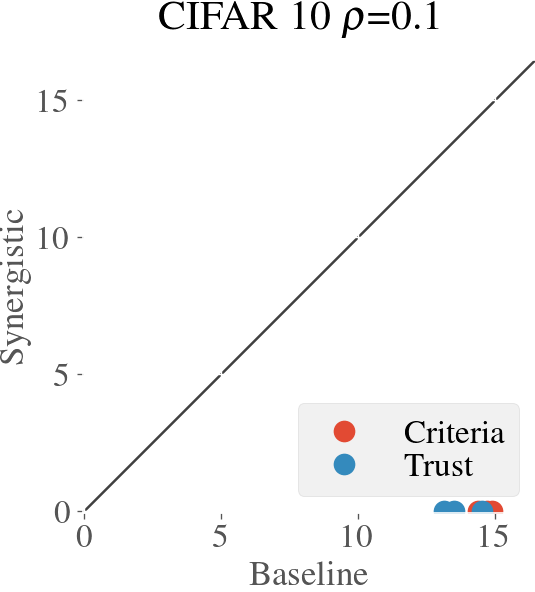

In [22]:
# Report tables arrangement
synergistic_cv = report_table_concat[['fold','%loss_red_test','rho_user']]    ; synergistic_cv.columns = ['syn_%loss_red_test' if x=='%loss_red_test' else x for x in synergistic_cv.columns]
criteria_cv    = report_criteria_concat[['fold','%loss_red_test','rho_user']] 
trust_cv       = report_trust_concat[['fold','%loss_red_test','rho_user']] 
df_plot1       = pd.merge(synergistic_cv,criteria_cv,on=['fold','rho_user'],how='left') ; df_plot1['Baseline'] = 'Criteria' 
df_plot2       = pd.merge(synergistic_cv,trust_cv,on=['fold','rho_user'],how='left')    ; df_plot2['Baseline'] = 'Trust'
df_plot        = df_plot1.append(df_plot2, ignore_index=True)

#Plot. percentage loss reduction on test data
rho_cv         = 0.10
df_plot_gr     = df_plot[df_plot.rho_user==rho_cv].groupby('Baseline')

fig,ax = plt.subplots(sharey=True,figsize=(5,5),dpi=120)
fig.suptitle('CIFAR 10 '+r'$\rho$'+'='+ str(rho_cv))
ax.set(facecolor = "white",xlabel='Baseline', ylabel='Synergistic')

for name, group in df_plot_gr:
    ax.plot(group['%loss_red_test'], group['syn_%loss_red_test'], marker='o', linestyle='', ms=12, label=name)

ax.legend(loc='lower right', framealpha=0.5, prop={'size':20}, labelspacing=0.0)

lims = [np.min([ax.get_xlim(), ax.get_ylim()])*0.9,np.max([ax.get_xlim(), ax.get_ylim()])*1.1]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims) ; ax.set_ylim(lims)

### Complementary retrieval

In [17]:
signaled_idx['syn_and_crit_0.10'] =   np.where(signaled_idx['syn_rho_grid_0.1']	 & signaled_idx['crit_rho_grid_0.1'],'A.Both signaled', 
                                      np.where(signaled_idx['syn_rho_grid_0.1']	 & ~ signaled_idx['crit_rho_grid_0.1'], 'B.Synergistic only signal',
                                      np.where(~ signaled_idx['syn_rho_grid_0.1'] & signaled_idx['crit_rho_grid_0.1'], 'C.Baseline only signal', 'D.Nether signaled')))
signaled_idx['syn_and_crit_0.15'] =   np.where(signaled_idx['syn_rho_grid_0.15']	 & signaled_idx['crit_rho_grid_0.15'],'A.Both signaled', 
                                      np.where(signaled_idx['syn_rho_grid_0.15']	 & ~ signaled_idx['crit_rho_grid_0.15'], 'B.Synergistic only signal',
                                      np.where(~ signaled_idx['syn_rho_grid_0.15'] & signaled_idx['crit_rho_grid_0.15'], 'C.Baseline only signal', 'D.Nether signaled')))

signaled_idx['syn_and_trust_0.10'] =  np.where(signaled_idx['syn_rho_grid_0.1']	 & signaled_idx['trust_rho_grid_0.1'],'A.Both signaled', 
                                      np.where(signaled_idx['syn_rho_grid_0.1']	 & ~ signaled_idx['trust_rho_grid_0.1'], 'B.Synergistic only signal',
                                      np.where(~ signaled_idx['syn_rho_grid_0.1'] & signaled_idx['trust_rho_grid_0.1'], 'C.Baseline only signal', 'D.Nether signaled')))
signaled_idx['syn_and_trust_0.15'] =  np.where(signaled_idx['syn_rho_grid_0.15']	 & signaled_idx['trust_rho_grid_0.15'],'A.Both signaled', 
                                      np.where(signaled_idx['syn_rho_grid_0.15']	 & ~ signaled_idx['trust_rho_grid_0.15'], 'B.Synergistic only signal',
                                      np.where(~ signaled_idx['syn_rho_grid_0.15'] & signaled_idx['trust_rho_grid_0.15'], 'C.Baseline only signal', 'D.Nether signaled')))

col_names = ['syn_and_crit_0.10','syn_and_crit_0.15','syn_and_trust_0.10','syn_and_trust_0.15']

In [18]:
loss_t        = np.sum(signaled_idx.Loss)
for idx,name in enumerate(col_names):    
  tmp_df = pd.pivot_table(signaled_idx, values='Loss', index=name, aggfunc=np.sum)  
  tmp_df = round(100*(tmp_df/loss_t),2)
  tmp_df = pd.DataFrame(pd.concat([pd.DataFrame({'Index': tmp_df.index.tolist()}),pd.DataFrame({tmp_df.index.name: tmp_df.Loss.tolist()})],axis=1))
  if idx == 0:
    results_loss = tmp_df
  else:
    results_loss= pd.merge(results_loss,tmp_df,on='Index',how='left')
results_loss    

,Index,syn_and_crit_0.10,syn_and_crit_0.15,syn_and_trust_0.10,syn_and_trust_0.15
0,C.Baseline only signal,14.7,21.64,14.52,21.92
1,D.Nether signaled,85.3,78.36,85.48,78.08


# Output visualization

In [19]:
rho = 0.15
X_test_best = X_test_best.squeeze()
rule = table_best.loc[table_best.rho_user == rho]['rule'].to_numpy()
eta = table_best.loc[table_best.rho_user == rho]['eta'].to_numpy()[0]
theta = crit_table_best.loc[crit_table_best.rho_user == rho]['thresh'].to_numpy()[0]
f_test = exp_best.gpr_mean_test+rule*np.sqrt(exp_best.gpr_var_test)
top_n = 5 # Top n selected instances in test set
top_f_idx = np.argpartition(f_test, -top_n)[-top_n:]
top_f_idx = top_f_idx[np.argsort(f_test[top_f_idx])[::-1]]# Added
# p_test = np.concatenate((y_test_pred_soft_best,1-y_test_pred_soft_best),axis=1)
crit_test = entropy(y_test_pred_soft_best, axis=1, base=10)
top_crit_idx = np.argpartition(crit_test, -top_n)[-top_n:]
top_crit_idx = top_crit_idx[np.argsort(crit_test[top_crit_idx])[::-1]]# Added

output_text = io.StringIO()
print('eta={:.3f},theta={:.3f}'.format(eta,theta))

eta=0.404,theta=0.833


In [20]:
roc_f = metrics.roc_auc_score(exp_best.L_test, f_test)
roc_crit = metrics.roc_auc_score(exp_best.L_test, crit_test)

Text(0, 0.5, '$g(x)>\\theta$\n$(AUC=0.72)$')

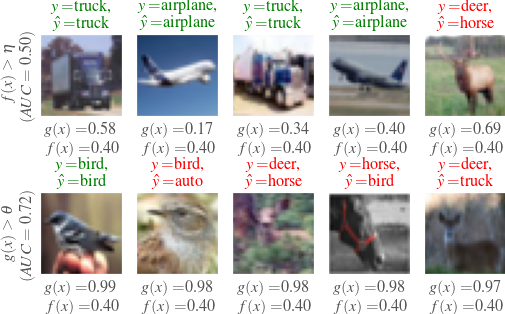

In [21]:
# Plot selected instances
# initialize the label 
labelNames = ['airplane', 'auto', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# X_test_best = X_test.reshape(-1,28,28)
# y_hat_best = y_test_pred_th[top_f_idx]
# y_th_best = np.argmax(y_test[top_f_idx], axis=1)
# Plot instances
row,col = 2,top_n
fig1, ax = plt.subplots(row, col, figsize=(6.0, 3.5), constrained_layout=True, dpi=90)
# fig1.subplots_adjust(wspace=0.1, hspace=0.35, top=0.5)
# for i in top_f_idx:
j = 0
for i,k in zip(top_f_idx, top_crit_idx):
    if np.argmax(y_test_best, axis=1)[i] != y_test_pred_th_best[i]:
        color = 'red'
    else:
        color = 'green'
    # ax = fig1.add_subplot(3, 4, j+1)
    ax[0][j].imshow(X_test_best[i, :, :, :])
    ax[0][j].set_title(r'$y=${s1}'.format(s1=labelNames[np.argmax(y_test_best, axis=1)[i]])+',\n'+\
                    r'$\hat{{y}}=${s2}'.format(s2=labelNames[y_test_pred_th_best[i]]), color=color, fontsize=13)
    ax[0][j].set_xlabel(r'$g(x)=${:.2f}'.format(crit_test[i])+'\n$f(x)=${:.2f}'.format(f_test[i]), fontsize=13)
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    if np.argmax(y_test_best, axis=1)[k] != y_test_pred_th_best[k]:
        color = 'red'
    else:
        color = 'green'
    # ax = fig1.add_subplot(3, 4, j+1)
    ax[1][j].imshow(X_test_best[k, :, :, :])
    ax[1][j].set_title(r'$y=${s1}'.format(s1=labelNames[np.argmax(y_test_best, axis=1)[k]])+',\n'+\
                    r'$\hat{{y}}=${s2}'.format(s2=labelNames[y_test_pred_th_best[k]]), color=color, fontsize=13)
    ax[1][j].set_xlabel(r"$g(x)=${:.2f}".format(crit_test[k])+'\n$f(x)=${:.2f}'.format(f_test[k]), fontsize=13)
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])
    j = j + 1
fig1.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0.01, wspace=-.5)
ax[0][0].set_ylabel(r"$f(x)>\eta$"+"\n"+r"$(AUC={:.2f})$".format(roc_f), fontsize=13)
# ax[0][0].set_ylabel(r"$f(x)>\eta$", fontsize=14)
ax[1][0].set_ylabel(r"$g(x)>\theta$"+"\n"+r"$(AUC={:.2f})$".format(roc_crit), fontsize=13)
# ax[1][0].set_ylabel(r"$g(x)>\theta$", fontsize=14)

# fig1.text(0.5, 0.01, r'$\rho={},~|f(x)>\eta|={},~|g(x)>\theta|={}$'.format(rho,np.sum(f_test>eta),np.sum(crit_test>theta)), ha='center', fontsize = 12)
# plt.suptitle(r'Top {} selected instances'.format(top_n), fontsize=15)
# plt.tight_layout()
# path_fig_fxgx_test = "drive/My Drive/NIPS2020/results/cifar10/fig_fxgx_test_{clf}_yhat{yhat}_pca{pca}.svg".format(clf=clf, pca=applyPCA, yhat=addPredictions)
# plt.savefig(path_fig_fxgx_test, bbox_inches='tight', facecolor='w')